In [9]:
# let's import important libraries
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import seaborn as sns

## Let's train the model for detect anomalies using orientaion x

In [25]:
# truncate the full data to check only orientation x

dataframe = pd.read_csv('../extract-data/ICAB1/02_icab1_reverse_fail_overtaking0_2021-03-26-14-40-28_0/icab1-mavros-imu-data.csv')
df = dataframe[['Time', 'orientation.x']]

#convert time step to the date and time format
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df

c:\python38\cv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Time,orientation.x
0,2021-03-26 13:40:28.646412544,-0.036490
1,2021-03-26 13:40:28.646579456,-0.036553
2,2021-03-26 13:40:28.646862592,-0.036523
3,2021-03-26 13:40:28.647303936,-0.036695
4,2021-03-26 13:40:28.648034048,-0.036460
...,...,...
754,2021-03-26 13:40:57.867936768,-0.026291
755,2021-03-26 13:40:57.903958272,-0.026335
756,2021-03-26 13:40:57.946675968,-0.026449
757,2021-03-26 13:40:57.981791232,-0.026561


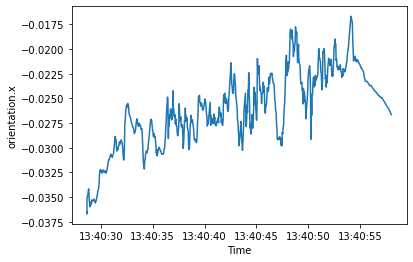

In [26]:
# plot the variation vs time in hh:mm:ss format
sns.lineplot(x=df['Time'], y=df['orientation.x'])

In [27]:
# print the start and ending dates for collecting datas
print("Start date is: ", df['Time'].min())
print("End date is: ", df['Time'].max())

Start date is:  2021-03-26 13:40:28.646412544
End date is:  2021-03-26 13:40:58.023969280


In [32]:
#Divide the whole data set to training & testing sets according to time
train, test = df.loc[df['Time'] <= '2021-03-26 13:40:50'], df.loc[df['Time'] > '2021-03-26  13:40:50']
train, test

(                             Time  orientation.x
 0   2021-03-26 13:40:28.646412544      -0.036490
 1   2021-03-26 13:40:28.646579456      -0.036553
 2   2021-03-26 13:40:28.646862592      -0.036523
 3   2021-03-26 13:40:28.647303936      -0.036695
 4   2021-03-26 13:40:28.648034048      -0.036460
 ..                            ...            ...
 553 2021-03-26 13:40:49.821355008      -0.026506
 554 2021-03-26 13:40:49.862577408      -0.025726
 555 2021-03-26 13:40:49.906171904      -0.025165
 556 2021-03-26 13:40:49.952451584      -0.024310
 557 2021-03-26 13:40:49.984463616      -0.023150
 
 [558 rows x 2 columns],
                              Time  orientation.x
 558 2021-03-26 13:40:50.023677184      -0.022653
 559 2021-03-26 13:40:50.063078912      -0.022080
 560 2021-03-26 13:40:50.103069440      -0.021957
 561 2021-03-26 13:40:50.143294208      -0.021698
 562 2021-03-26 13:40:50.183240960      -0.022431
 ..                            ...            ...
 754 2021-03-26 13:40:5

In [34]:
scaler = StandardScaler()
scaler = scaler.fit(train[['orientation.x']])

train['orientation.x'] = scaler.transform(train[['orientation.x']])
test['orientation.x'] = scaler.transform(test[['orientation.x']])


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['orientation.x']], train['orientation.x'], seq_size)
testX, testY = to_sequences(test[['orientation.x']], test['orientation.x'], seq_size)


# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(RepeatVector(trainX.shape[1]))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(trainX.shape[2])))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#model.evaluate(testX, testY)

###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['orientation.x'] = test[seq_size:]['orientation.x']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Time'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Time'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['Time'], y=scaler.inverse_transform(anomaly_df['orientation.x']))
sns.scatterplot(x=anomalies['Time'], y=scaler.inverse_transform(anomalies['orientation.x']), color='r')

c:\python38\cv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
c:\python38\cv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

ValueError: view limit minimum -36893.77850580091 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36893.77850580091 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units